# AWS Data Ingestion Cost Analysis

This notebook presents a cost analysis of different AWS services for data ingestion, including Kinesis Firehose, IoT MQTT, and S3 PutObjects.

The cost analysis is based on a scenario where data is being sent at a rate of 100 messages per second from each of 40 devices, for a total of 4000 messages per second. The costs are calculated over a period of up to 720 hours (30 days).

The costs for Kinesis Firehose and IoT MQTT are based on the volume of raw data. For S3 PutObjects, the data is assumed to be compressed and batched into fewer PUT requests, which significantly reduces the cost - atleast for larger batch sizes.

The results are presented in two graphs:
- The first graph shows the costs as the volume of data increases, for different batch sizes for S3 PutObjects (from 1 to 100,000 records per PUT request), compared to Kinesis Firehose and IoT MQTT.
- The second graph shows the costs for larger batch sizes (from 1000 to 100,000 records per PUT request), making the comparison between S3 PutObjects and Kinesis Firehose more clear.

The batch size is the number of records included in each PUT request. The cost of S3 PutObjects decreases as the batch size increases because the cost per PUT request is reduced.


In [ ]:
%pip install matplotlib numpy

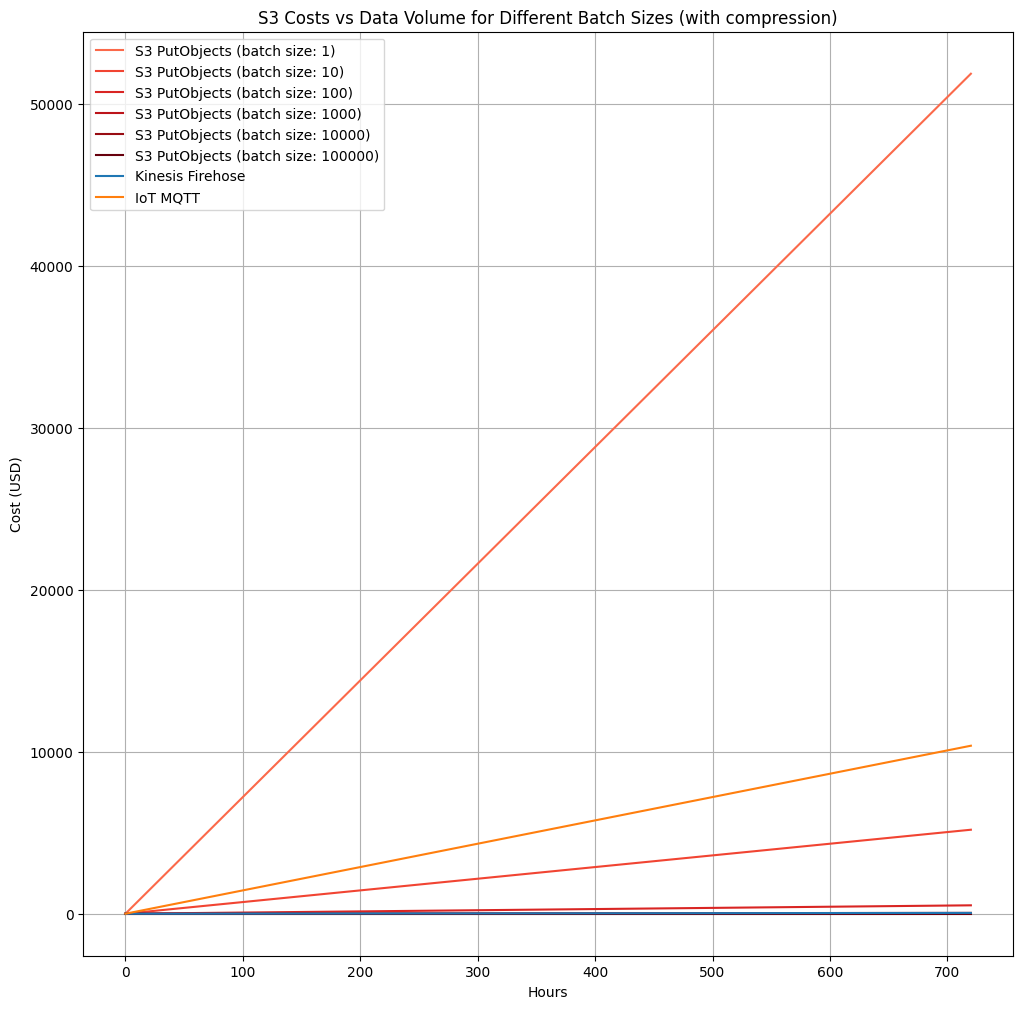

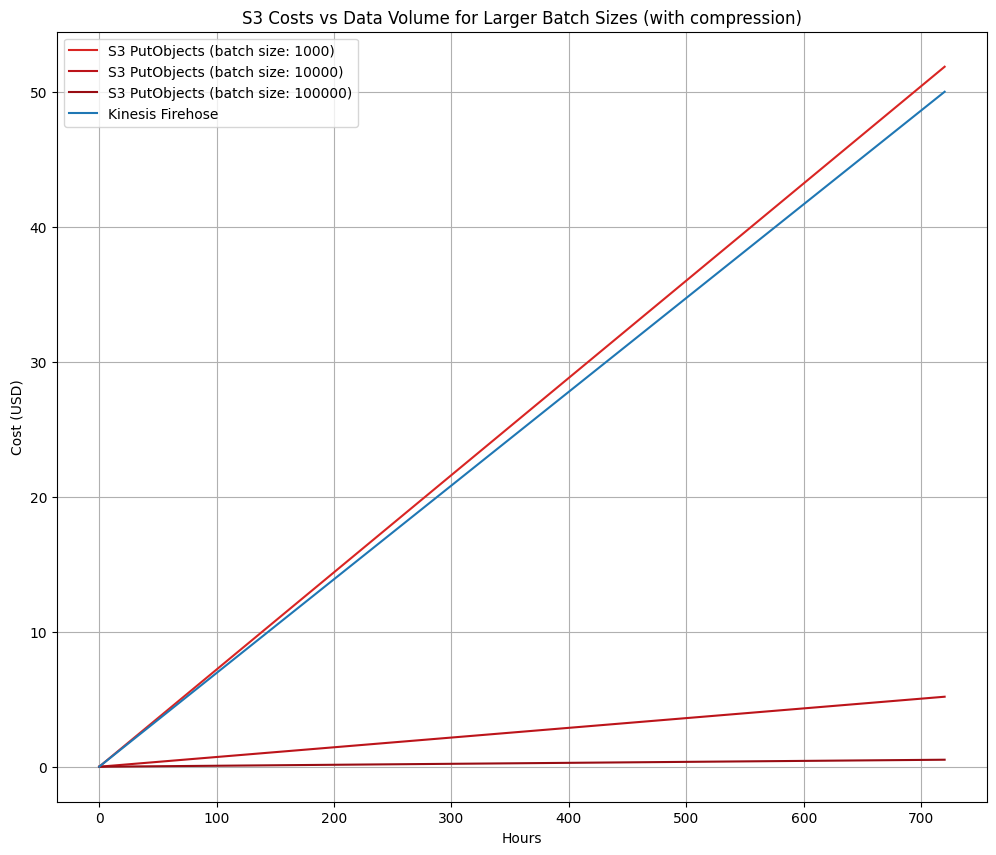

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Constants for AWS pricing
firehose_cost_per_gb = 0.029  # dollars
mqtt_cost_per_message = 1 / 1e6  # dollars
s3_cost_per_gb = 0.023  # dollars
s3_cost_per_put = 0.005 / 1e3  # dollars

# Constants for the data
records_per_second = 100 * 40  # records
record_size_bytes = 166.25  # bytes
hours = np.linspace(0, 720, num=100)  # up to 30 days

# Calculate the compression ratio from the provided file
raw_data_size = record_size_bytes * records_per_second * 3600  # Size of an hour's worth of raw data in bytes
compressed_data_size = 3129  # Size of the compressed data file in bytes
compression_ratio = compressed_data_size / raw_data_size

def calculate_costs_firehose_mqtt(hours):
    seconds = hours * 3600  # convert hours to seconds
    records = records_per_second * seconds  # total number of records
    raw_data_gb = records * record_size_bytes / 1e9  # total raw data volume in GB

    # Calculate costs for each service
    firehose_cost = raw_data_gb * firehose_cost_per_gb
    mqtt_cost = records * mqtt_cost_per_message

    return firehose_cost, mqtt_cost

# Function to calculate S3 cost with compression for different batch sizes
def calculate_s3_cost_with_compression(batch_size, hours):
    seconds = hours * 3600  # convert hours to seconds
    records = records_per_second * seconds  # total number of records
    raw_data_gb = records * record_size_bytes / 1e9  # total raw data volume in GB
    compressed_data_gb = raw_data_gb * compression_ratio  # total compressed data volume in GB

    # Calculate S3 cost for the given batch size
    puts = records / batch_size  # total number of PUT requests
    s3_cost = puts * s3_cost_per_put + compressed_data_gb * s3_cost_per_gb

    return s3_cost

# Define batch sizes to compare
compare_batch_sizes = [1, 10, 100, 1000, 10000, 100000]

# Define a color map for the lines
colors = plt.cm.Reds(np.linspace(0.5, 1, len(compare_batch_sizes)))

# Plot the costs vs data volume for each batch size
plt.figure(figsize=(12, 12))
for i, batch_size in enumerate(compare_batch_sizes):
    s3_costs = np.vectorize(lambda hours: calculate_s3_cost_with_compression(batch_size, hours))(hours)
    plt.plot(hours, s3_costs, label=f'S3 PutObjects (batch size: {batch_size})', color=colors[i])

# Plot the costs vs data volume for Kinesis Firehose and IoT MQTT
costs = np.vectorize(calculate_costs_firehose_mqtt)(hours)
plt.plot(hours, costs[0], label='Kinesis Firehose')
plt.plot(hours, costs[1], label='IoT MQTT')

plt.xlabel('Hours')
plt.ylabel('Cost (USD)')
plt.title('S3 Costs vs Data Volume for Different Batch Sizes (with compression)')
plt.legend()
plt.grid(True)
plt.show()

# Plot the costs vs data volume for larger batch sizes (1000+) along with Kinesis Firehose
plt.figure(figsize=(12, 10))
for i, batch_size in enumerate(compare_batch_sizes[3:]):  # Exclude batch sizes 1, 10, 100
    s3_costs = np.vectorize(lambda hours: calculate_s3_cost_with_compression(batch_size, hours))(hours)
    plt.plot(hours, s3_costs, label=f'S3 PutObjects (batch size: {batch_size})', color=colors[i+2])

# Plot the costs vs data volume for Kinesis Firehose
costs = np.vectorize(calculate_costs_firehose_mqtt)(hours)
plt.plot(hours, costs[0], label='Kinesis Firehose')

plt.xlabel('Hours')
plt.ylabel('Cost (USD)')
plt.title('S3 Costs vs Data Volume for Larger Batch Sizes (with compression)')
plt.legend()
plt.grid(True)
plt.show()
